# Clickbait Detection using only headline

### Mounting the drive (you can ignore this)

In [1]:
# conecting to the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Downloading the dataset at the right location in the google drive and extracting it.
-- You can ignore this.

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [3]:
#changing the working directory

%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [4]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
# downloading the dataset into the drive
!kaggle competitions download -c clickbait-news-detection

 96% 27.0M/28.1M [00:00<00:00, 69.6MB/s]
100% 28.1M/28.1M [00:00<00:00, 81.0MB/s]
 91% 7.00M/7.68M [00:00<00:00, 71.0MB/s]
100% 7.68M/7.68M [00:00<00:00, 70.7MB/s]
  0% 0.00/4.04M [00:00<?, ?B/s]
100% 4.04M/4.04M [00:00<00:00, 66.5MB/s]
  0% 0.00/54.1k [00:00<?, ?B/s]
100% 54.1k/54.1k [00:00<00:00, 7.63MB/s]
 93% 101M/109M [00:01<00:00, 82.1MB/s] 
100% 109M/109M [00:01<00:00, 86.4MB/s]


In [5]:
!ls

clickbait-news-detection  test.csv	       train.csv.zip	  valid.csv.zip
kaggle.json		  test.csv.zip	       unlabeled.csv
sample_submission.csv	  thumbnail-clickbait  unlabeled.csv.zip
saved_weights.pt	  train.csv	       valid.csv


In [ ]:
!unzip \*.zip

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

Archive:  valid.csv.zip
  inflating: valid.csv               

Archive:  unlabeled.csv.zip
  inflating: unlabeled.csv           

4 archives were successfully processed.


### Importing libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
import os, sys, shutil
import time
import gc
from contextlib import contextmanager
from pathlib import Path
import random
import numpy as np, pandas as pd
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelBinarizer
import torch
import torch.nn as nn
import torch.utils.data

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']

In [8]:
!pip3 install transformers
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

     |████████████████████████████████| 2.2MB 19.8MB/s 
     |████████████████████████████████| 3.3MB 53.6MB/s 
     |████████████████████████████████| 870kB 50.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e0fd9af8a92a2d453c148a8932f0d9f6bbe53f3e7f43c1c00f70758ec230f19f
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [19]:
!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast


In [20]:
device = torch.device('cuda')

### Downloading the pre-trained BERT model and verifying it with an example

In [21]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [23]:
## Please uncomment this and comment the next pd.read_csv if executing on local machine
# train_df = pd.read_csv('./Dataset/clickbait-news-detection/train.csv')
# test_df = pd.read_csv('./Dataset/clickbait-news-detection/test.csv')
# val_df = pd.read_csv('./Dataset/clickbait-news-detection/valid.csv')

train_df=pd.read_csv('/content/gdrive/MyDrive/Kaggle/train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Kaggle/test.csv')
valid_df=pd.read_csv('/content/gdrive/MyDrive/Kaggle/valid.csv')

In [24]:
test_df

,id,title,text
0,0,Amazon CEO Jeff Bezos is now the second riches...,More Try Yahoo Finance on Firefox » Amazon CEO...
1,1,Does Laura Dern Handle a Lightsaber in the New...,More Laura Dern seems to be everywhere these d...
2,2,"In this photographer’s home town, stepping out...",Kirkuk is a city of Northern Iraq in the Kurdi...
3,3,"8 Ways To Get Your Spouse To Open Up More, Acc...",Experts say that communication is the cornerst...
4,4,US says claim it supported IS in Syria is 'lud...,Share this with Email Facebook Messenger Messe...
...,...,...,...
5642,5642,Watch Out Boy! Today in 1982 Hall & Oates Took...,"“Watch out boy, she’ll chew you up.” On this d..."
5643,5643,Dubai fire: apartment block on artificial Palm...,Fire broke out at an upmarket apartment block ...
5644,5644,"There Are More Than 60,000 Species Of Trees In...","For the first time, a database has compiled a ..."
5645,5645,Vin Diesel: 'Guardians of the Galaxy' Director...,Vin Diesel has sometimes been known to jump th...


In [25]:
train_df=train_df.dropna().reset_index().drop(labels=['id','index'],axis=1)
valid_df=valid_df.dropna().reset_index().drop(labels=['id','index'],axis=1)

In [26]:
train_df

,title,text,label
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news
...,...,...,...
19872,A very interesting user generated content website,let me know what you think,other
19873,"Unable to Enter U.S., and Still Stranded Abroa...","AMSTERDAM — Pedram Paragomi, a Iranian medical...",news
19874,"Calais Migrant Camp Will Be Demolished Soon, F...",(AFP) — The total dismantling of the “Jungle” ...,news
19875,Twitter’s NFL Deal No Cure for User and Advert...,Gaining the worldwide rights to stream 10 NFL ...,news


We will use the train_df appended with the valid_df as the entire dataset does not have labels

In [27]:
train_df=train_df.append(valid_df,ignore_index=True)

In [28]:
valid_df

,title,text,label
0,Trump says he is releasing something 'phenomen...,"Bob Bryan, Business Insider 9.02.2017, 16:25 1...",news
1,Fidel Castro's ashes make their final journey ...,Cubans have been lining the streets from Havan...,news
2,Obama Administration Sending $500 Million to G...,WASHINGTON—The Obama administration announced ...,news
3,Insurers Are Worried About The House GOP Healt...,The main industry groups representing health i...,news
4,Kobe Bryant and Nike Form Youth Basketball 'Ma...,A year after Kobe Bryant concluded his NBA car...,news
...,...,...,...
2819,The New Playboy and the End of Adulthood,"As I began writing this column, I checked Play...",news
2820,Use of weaponized drones by ISIS spurs terrori...,"Late last month, a pair of Islamic State fight...",news
2821,Experts: China might be building database of f...,Washington (CNN) The massive hack that may hav...,news
2822,How Trump Can Fix His Troubled White House,"Reports of chaos, confusion, and infighting se...",news


In [29]:
train_df

,title,text,label
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news
...,...,...,...
22696,The New Playboy and the End of Adulthood,"As I began writing this column, I checked Play...",news
22697,Use of weaponized drones by ISIS spurs terrori...,"Late last month, a pair of Islamic State fight...",news
22698,Experts: China might be building database of f...,Washington (CNN) The massive hack that may hav...,news
22699,How Trump Can Fix His Troubled White House,"Reports of chaos, confusion, and infighting se...",news


### Pre-processing

In [30]:
temp = list(train_df['title'])
indices=[]
count=0
for i,item in enumerate(temp):
  if len(item.split()) > 50:
    indices.append(i)
    count+=1
    #print(item)
    #print(i)
print(count)


71


In [31]:
train_df=train_df.drop(labels=indices).reset_index().drop(['index'],axis=1)

In [32]:
train_df=train_df[train_df['label']!='other'].reset_index().drop(['index'],axis=1)

In [33]:
mylist=[]
for label in list(train_df['label']):
  if label == 'clickbait':
    mylist.append(1)
  else:
    mylist.append(0)
train_df['label_int']=mylist
train_df

,title,text,label,label_int
0,China and Economic Reform: Xi Jinping’s Track ...,Economists generally agree: China must overhau...,news,0
1,Trade to Be a Big Topic in Theresa May’s U.S. ...,LONDON—British Prime Minister Theresa May said...,news,0
2,"The Top Beaches In The World, According To Nat...",Beaches come in all sorts of shapes and sizes ...,clickbait,1
3,Sheriff’s Report Provides New Details on Tamir...,"A timeline of what happened after Tamir Rice, ...",clickbait,1
4,Surgeon claiming he will transplant volunteer'...,An Italian neurosurgeon who has claimed for mo...,news,0
...,...,...,...,...
20878,The New Playboy and the End of Adulthood,"As I began writing this column, I checked Play...",news,0
20879,Use of weaponized drones by ISIS spurs terrori...,"Late last month, a pair of Islamic State fight...",news,0
20880,Experts: China might be building database of f...,Washington (CNN) The massive hack that may hav...,news,0
20881,How Trump Can Fix His Troubled White House,"Reports of chaos, confusion, and infighting se...",news,0


In [34]:
#train_text,test_text,valid_text=train_df['title'],test_df['title'],valid_df['title']
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(train_df['title'], train_df['label_int'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train_df['label_int'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

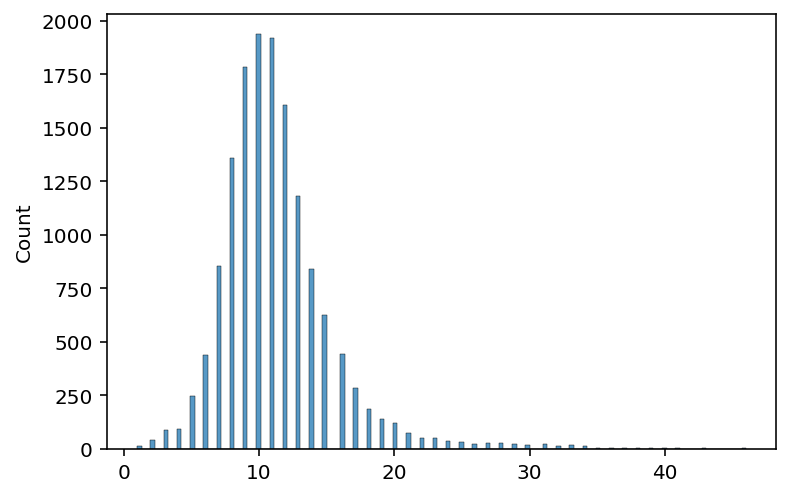

In [35]:
# get length of all the messages in the train set
import seaborn as sns
seq_len = [len(i.split()) for i in train_text]

sns.histplot(seq_len)

In [36]:
seq_len.index(max(seq_len))

14242

### Tokenizing the headlines

In [38]:
# tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Creating data loaders

In [40]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [41]:
set(list(train_df['label']))

{'clickbait', 'news'}

In [42]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Defining the Architecture

In [73]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      # self.dropout = nn.Dropout(0.3)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      #self.fc1 = nn.Linear(768,2)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.Softmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      # x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      #x = self.dropout(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [74]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [75]:
# optimizer from hugging face transformers
from transformers import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5) 
#optimizer = Adam(model.parameters(),lr=2e-5)

clickbait:  4244
news:  16639


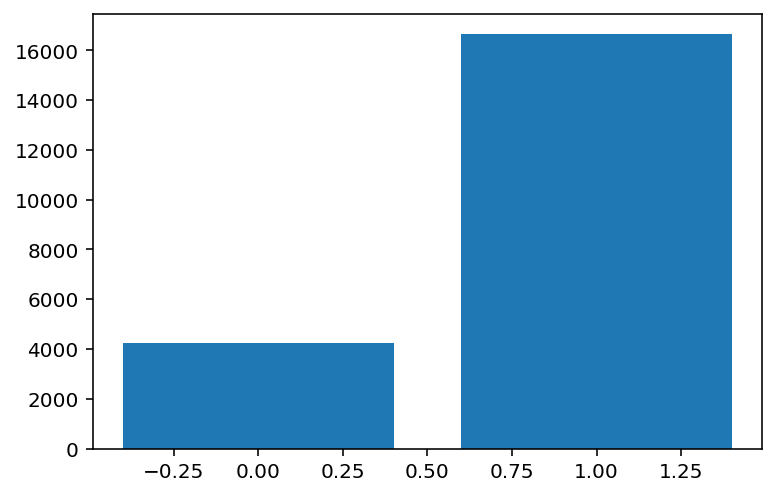

In [76]:
# check for class imbalance
count1=0
count2=0
for i in mylist:
  if i == 1:
    count1+=1
  else:
    count2+=1
print('clickbait: ',count1 )
print('news: ',count2)
#sns.barplot(x=range(2),y=[count1,count2])
count=[count1,count2]
plt.bar(range(len(count)), count)
plt.show()

In [77]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.62754357 2.46011444]


In [78]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy = nn.CrossEntropyLoss(weight=weights)
# number of training epochs
epochs = 15

In [79]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [80]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
     # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [81]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15
  Batch    50  of    457.
  Batch   100  of    457.
  Batch   150  of    457.
  Batch   200  of    457.
  Batch   250  of    457.
  Batch   300  of    457.
  Batch   350  of    457.
  Batch   400  of    457.
  Batch   450  of    457.

Evaluating...
  Batch    50  of     98.

Training Loss: 0.681
Validation Loss: 0.670

 Epoch 2 / 15
  Batch    50  of    457.
  Batch   100  of    457.
  Batch   150  of    457.
  Batch   200  of    457.
  Batch   250  of    457.
  Batch   300  of    457.
  Batch   350  of    457.
  Batch   400  of    457.
  Batch   450  of    457.

Evaluating...
  Batch    50  of     98.

Training Loss: 0.662
Validation Loss: 0.657

 Epoch 3 / 15
  Batch    50  of    457.
  Batch   100  of    457.
  Batch   150  of    457.
  Batch   200  of    457.
  Batch   250  of    457.
  Batch   300  of    457.
  Batch   350  of    457.
  Batch   400  of    457.
  Batch   450  of    457.

Evaluating...
  Batch    50  of     98.

Training Loss: 0.652
Validation Loss: 0

### Plotting the test and validition loss

```
# This is formatted as code
```



No handles with labels found to put in legend.


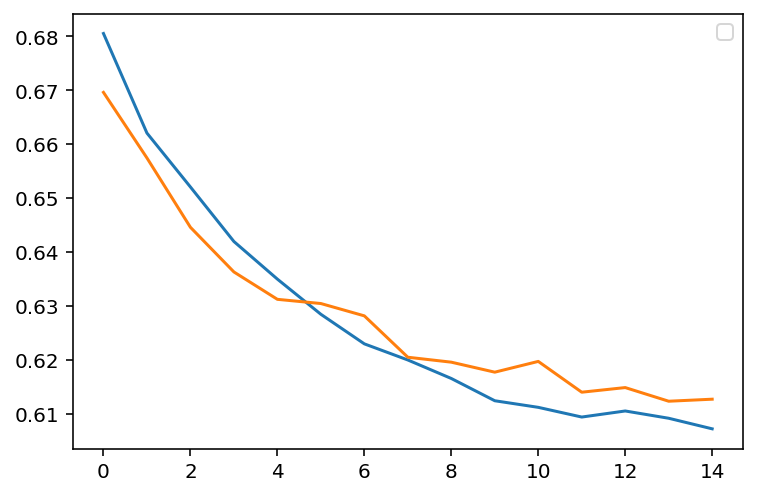

In [82]:
sns.lineplot(data=train_losses)
sns.lineplot(data=valid_losses)
plt.legend()
plt.show()

### Evaluating on test set

In [83]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [84]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2496
           1       0.38      0.55      0.45       637

    accuracy                           0.73      3133
   macro avg       0.63      0.66      0.63      3133
weighted avg       0.77      0.73      0.74      3133



In [89]:
preds

array([0, 1, 0, ..., 0, 1, 0])

In [90]:
test_y

tensor([0, 1, 0,  ..., 0, 0, 0])

# ClickBait with Thumbnails

### Importing Libraries

In [91]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import Variable
import torchvision.models as models
from torch.autograd import Variable


from PIL import Image
%matplotlib inline

In [92]:
#data_dir = "/content/gdrive/MyDrive/Kaggle/thumbnail-clickbait/clickbait-thumbnail-detection/thumbnails/"
data_dir = "./Dataset/clickbait-thumbnail-detection/thumbnails"

In [93]:
import pandas as pd
#mydf=pd.read_csv('/content/gdrive/MyDrive/Kaggle/thumbnail-clickbait/clickbait-thumbnail-detection/train.csv')
mydf = pd.read_csv('./Dataset/clickbait-thumbnail-detection/train.csv')
mydf

,ID,title,description,timestamp,viewCount,likeCount,dislikeCount,commentCount,user_comment_1,user_comment_2,user_comment_3,user_comment_4,user_comment_5,user_comment_6,user_comment_7,user_comment_8,user_comment_9,user_comment_10,URL,class
0,wutdQ_kzNn0,MARZIA HAS LIGMA LWIAY #0044,Become Sponsor: https://youtube.com/pewdiepie/...,2018-08-03T17:45:01.000Z,10509398.0,945921.0,5614.0,58844,Other man: *touches Marzia's hand*\nPewds: som...,**marzia is in a video**\n\n**pewds quality in...,8:51 Proof that Italians do the hand thing whe...,"Me: Mom can we have LWIAY intro?\nMom: No, we ...",Nobody:\nYoutube: Let's recommend this video 9...,Felix you did not disappoint with that outro,belle delphine: eats pewdiepie\n\n\nMarzia: SO...,The Italian words pewds said roughly translate...,Marzia- how about watching old videos \n\nMe i...,outro: *Fire*\nscreen: *black*\nFelix: is that...,https://www.youtube.com/watch?v=wutdQ_kzNn0,True
1,WVaLM-kIZgg,This Slinky Montage Is Bizarrely Satisfying to...,Happy National Slinky Day! We got our hands on...,2018-08-30T12:00:09.000Z,4829.0,57.0,81.0,22,neither bizarre nor satisfying. barely watchab...,You could have just played the scene from Ace ...,When the new toy in the office becomes everybo...,"Almost so satisfying, slinky occasionally land...",There is something strangely satisfying in wat...,"Now that I think of it, slinkys are insanely w...",S L I N K Y P O R N,That stairwell is definitely coated in urine.,wtf has happened to your content,They're like unknown creatures moving down the...,https://www.youtube.com/watch?v=WVaLM-kIZgg,False
2,cKAKayQ4F9o,MAKING HER DREAM COME TRUE! (MAKE A WISH),It was so nice to meet you Trinity 😊\nGET NEW ...,2018-08-07T20:08:28.000Z,1015456.0,36679.0,492.0,3739,Follow me on Instagram @Lance210,Another proof you have a big heart ❤,She still has not used any of that money she i...,Im 12 my name is cyrus and i have severe asthm...,Lance is such a happy and productive person an...,I’ve had something called ugliness since I was...,I loved this u really made them girls day❤,The awkwardness was real😂😂😂!!!!!!,"Awkward, but really cool u could do that for t...",GOD BLESS you Lance,https://www.youtube.com/watch?v=cKAKayQ4F9o,True
3,ZwqOoD17_LU,Science Journalism: Crash Course Statistics #11,We’ve talked a lot in this series about how of...,2018-04-11T21:00:03.000Z,64629.0,2111.0,24.0,151,"It's not as simple as ""checking the source"". M...","This should go into media literacy, I think, i...",This episode should be correlated with CrashCo...,There's Media Literacy in my Statistics! Nice ...,Ah! She is just lovely! Excellent episode.,Loved the limerick.,"Article: ""a study found a mild correlation bet...",Videos like this should absolutely be regular ...,Love the poetry :-)\nIt's important to know wh...,"Bonus points for ""Partial Foods.""",https://www.youtube.com/watch?v=ZwqOoD17_LU,False
4,MhXDnHIOP9w,"Michelin and General Motors Unveil Airless, Pu...",Michelin and General Motors are betting on nea...,2019-06-19T13:09:00.000Z,206468.0,1335.0,96.0,470,Perfect can get spike stripped and still outru...,The tires have been in development for so long...,"How will they do on side loads, like high spee...","Michelin chill out, I work in roadside assista...",They look good but I hope it's enough to hold ...,"When you fail to present the downsides, you ju...",I am definitely going to pick up a set of thes...,Yeah but the real questions are; how much road...,They give in a lot. At least it looks like it....,We've seen various versions of this concept fo...,https://www.youtube.com/watch?v=MhXDnHIOP9w,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,wFU8plUZccs,A Relaxing Time With Just For Men,Please subscribe to my channel and my vlog cha...,2019-03-07T07:36:02.000Z,6276674.0,290190.0,1514.0,20274,Jenna's videos are BY FAR the easiest to re-wa...,"""Remember when we got in that car accident and...",“I don’t go outside”\n“I can tell”\n

### Checking out the shape, type and other properties of images
-- Uncomment cells if you want to see the images in the dataset



In [94]:
img_ids=list(mydf['ID'])
img_ids

['wutdQ_kzNn0',
 'WVaLM-kIZgg',
 'cKAKayQ4F9o',
 'ZwqOoD17_LU',
 'MhXDnHIOP9w',
 'kO27LbAKsjg',
 'Fg1B5W2TlcM',
 'Dv2zWnFMbmA',
 'QCwLZM_BL_M',
 '7BdVVeLLdAI',
 '-xbtnz4wdaA',
 '2nttDEDI54I',
 'AhaPyRGKQ5M',
 'ATojoFL-CBI',
 'hO_SzV6DaD0',
 '8ynclk6IS5g',
 '7nXvv4ClyIs',
 '_OdRiluqxO4',
 'sBBP0hW-ZCM',
 'waxuMpRyZr0',
 '4vvc8Cd1hEY',
 'r0Jodzn2t5M',
 'c9xZE3g-XJI',
 'hLOc0PnDDTY',
 'zXbortaLKDE',
 'tlFt522ei7k',
 'JZYzh-ySlfs',
 'kbi8b2t5CmE',
 'mJeLGd3JV2I',
 'ck1JW-_G2Yc',
 '-k3IUNZuA-g',
 'x0jIz3dZxnU',
 '7o4I0uDtqMg',
 'eXK9B-Uyoqo',
 'ARA0AxrnHdM',
 'QWB2l2gDqUw',
 '39MLkF21rgs',
 '2HNfdKcBuVI',
 '3Nu5RjfxVL4',
 'cU_TMypuHXs',
 '0-diECOzCnE',
 '-1Tg2-NuEVU',
 'BRBxtAF7s6w',
 'pp7YOTqKTWU',
 'F2-OboKKTlw',
 'fwX-39oEeIE',
 'NPuYtHZud0o',
 'BOa6HU_he2A',
 'pvR91fvLp5A',
 'B1CZXzd5mHs',
 'TGmhnWaByXE',
 'v05kJqPPilI',
 'sE53eSbzxoU',
 'FXW7Ii6QmpU',
 'vW_hMlcWihk',
 '3UxtKALtA1o',
 'Wi8BwUh3XOk',
 'umYdk596x9k',
 'dB4s4H4zuQk',
 '8UufG-n-mWs',
 'nXyvqWlvLl4',
 '5m2sk1ZUqwc',
 'U5tGd_

In [95]:
img1= Image.open(data_dir+img_ids[0]+'.jpg')

In [96]:
img1.info

{'jfif': 257, 'jfif_density': (1, 1), 'jfif_unit': 0, 'jfif_version': (1, 1)}

In [97]:
img1.size

(480, 360)

In [98]:
img2= Image.open(data_dir+img_ids[1]+'.jpg')
img2.mode

'RGB'

In [101]:
# img2

In [102]:
# img1

### Defining the transformations on images in order to feed into ResNet 18 Model

In [103]:
#crop=T.CenterCrop((300,480))
scaler = T.Scale((224, 224))
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = T.ToTensor()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [106]:
# crop=T.CenterCrop((300,480))
# t_img1 = Variable(normalize(to_tensor(scaler(crop(img1)))))

In [107]:
# plt.imshow(t_img1.permute(1, 2, 0))

In [108]:
# t_img1.shape

### Function to get the vector representation of Image (Just for testing)
-- You can ignore this

In [113]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [114]:
def get_vector(image_name):
    img = Image.open(image_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    my_embedding = feature_extractor(t_img)
    return my_embedding

In [115]:
img1_vec=get_vector(data_dir+img_ids[0]+'.jpg')

In [116]:
#model

In [117]:
img1_vec=img1_vec.reshape((-1,512))

In [ ]:
img1_vec.shape

torch.Size([1, 512])

### Defining the architecture for the model
There are three classes, one corresponding to BERT which gives the feature representation of text, one corresponding to resnet which gives the feature representation of the image and an ensemble model which concatenates both these outputs and uses a MLP on top as described (These are the trainable weights but we can chose to finetune BERT and ResNet as well)

In [118]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      #self.dropout = nn.Dropout(0.3)
      
      # relu activation function
      #self.relu =  nn.ReLU()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x=cls_hs
      return x

class myResNet(nn.Module):
    def __init__(self, resnet):
      
      super(myResNet, self).__init__()

      self.resnet = resnet 
    def forward(self,img):
      x = self.resnet(img)
      x = x.reshape((-1,512))
      return x
       
class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        #self.classifier = nn.Linear(768+512, 2)
      # dense layer 1
        self.fc1 = nn.Linear(768+512,512).to(device)
        self.fc2 = nn.Linear(512,2).to(device)
        self.relu =  nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, bert1, bert2,res1):
        x1 = self.modelA(bert1,bert2)
        x2 = self.modelB(res1)
        x = torch.cat((x1, x2), dim=1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.softmax(x)
        #x = self.classifier()
        return x


In [ ]:
# model = models.resnet18(pretrained=True).to(device)
# feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
# model1 = myResNet(feature_extractor)
# model1.to(device)

In [ ]:
# model1(img1).shape

### Cleaning the Dataframe a little

In [119]:
mydf=mydf.drop(labels=['timestamp',	'viewCount',	'likeCount','dislikeCount'	,'commentCount',	'user_comment_1'	,'user_comment_2'	,'user_comment_3'	,'user_comment_4',	'user_comment_5'	,'user_comment_6',	'user_comment_7'	,'user_comment_8',	'user_comment_9',	'user_comment_10','URL'],axis=1)

In [120]:
class_=[]
for i,row in mydf.iterrows():
  if row['class'] == True:
    class_.append(1)
  else:
    class_.append(0)
mydf['class_']=class_
mydf

,ID,title,description,class,class_
0,wutdQ_kzNn0,MARZIA HAS LIGMA LWIAY #0044,Become Sponsor: https://youtube.com/pewdiepie/...,True,1
1,WVaLM-kIZgg,This Slinky Montage Is Bizarrely Satisfying to...,Happy National Slinky Day! We got our hands on...,False,0
2,cKAKayQ4F9o,MAKING HER DREAM COME TRUE! (MAKE A WISH),It was so nice to meet you Trinity 😊\nGET NEW ...,True,1
3,ZwqOoD17_LU,Science Journalism: Crash Course Statistics #11,We’ve talked a lot in this series about how of...,False,0
4,MhXDnHIOP9w,"Michelin and General Motors Unveil Airless, Pu...",Michelin and General Motors are betting on nea...,False,0
...,...,...,...,...,...
7100,wFU8plUZccs,A Relaxing Time With Just For Men,Please subscribe to my channel and my vlog cha...,False,0
7101,R3GlwN8ju2E,Scientists Prove Beer Lovers May Be Healthier ...,----------------------------------------------...,True,1
7102,a__Y8G5qEuI,THE EVOLUTION OF FORTNITE! 2011 - 2019,Reacting To THE EVOLUTION OF FORTNITE! 2011 - ...,True,1
7103,WlriwanO4e4,India's trucks are works of art,Why India’s trucks are so colorful.\nSeason 2 ...,False,0


### Splitting the dataframe into train, test and validation sets

In [121]:
 traindf, valdf, testdf = \
              np.split(mydf.sample(frac=1, random_state=42), 
                       [int(.8*len(mydf)), int(.9*len(mydf))])

In [122]:
traindf

,ID,title,description,class,class_
6421,L9LcmaOYA5Q,Here's Why This Water Bottle is Worth $100,"Full Day w/ Food, Gym & How I got ABS → https:...",True,1
5681,tOctS0PNa_4,KID GETS CAUGHT STEALING,KID WHO GOT CAUGHT STEALING! Don't steal or yo...,True,1
4678,YhSImgCPYfs,Pewdiepie vs Tseries the Anime LWIAY - #0069,N E W M E R C H : https://represent.com/pewd...,True,1
4834,0h9UL_EizkE,Only 2 People Completed This IMPOSSIBLE Race B...,Only 2 People Completed This IMPOSSIBLE Race B...,True,1
5652,yQliow4ghtU,How a warmer Arctic could intensify extreme we...,Is there a link between the vanishing Arctic s...,False,0
...,...,...,...,...,...
6663,AUjugyDyYnA,FUNNIEST PASSIVE AGGRESSIVE NOTES,FUNNIEST PASSIVE AGGRESSIVE NOTES! A funny way...,True,1
6424,2zS8RmOnYwI,ASMR Unboxing Red's Holographic Hydrogen One P...,Digital cinema camera company Red recently unv...,False,0
6272,pK-G259VX6U,Guy Creates Fire With Bare Hands!! (IMPOSSIBLE),Thanks to #BangEnergy for sponsoring this vide...,False,0
6851,T4DMD9wdqog,In 1948 a Fighter Pilot Pursued a Mystery Spee...,----------------------------------------------...,True,1


In [123]:
testdf

,ID,title,description,class,class_
5772,_hBAr7uJ6L8,The surprising reasons animals play dead - Tie...,Check out our Patreon page: https://www.patreo...,False,0
5293,6mahB8pi_sc,Man Found In Vietnam Jungle After 40 Years Stu...,Click the link to subscribe: http://bit.ly/Fac...,True,1
1542,6B7vPTTc4yA,The Truth about FaZe Banks..,It's crazy how FaZe Banks really has changed m...,True,1
3301,8bU31q4J7Tk,Trump speaks following Mueller’s testimony | A...,SUBSCRIBE to ABC NEWS: https://www.youtube.com...,False,0
3324,umzbLnLghsQ,Getting ready to Leave the FaZe House for good,Moving out next week... a little scared but ex...,True,1
...,...,...,...,...,...
3772,1qyyXfQL5jU,You Laugh = You're a Gamer,You laugh you lose gaming edition\nSuppert the...,True,1
5191,yI3K0Us3Jlw,'Foul play was involved' in death of Universit...,Authorities are investigating the death of Ale...,False,0
5226,06JHIp5gU4c,Police bodycam video captures harrowing Iowa r...,Officers in Des Moines recovered two people tr...,False,0
5390,cUy82r73nRU,This Blind Cow Was Crying Every Night. When Yo...,Click the link to subscribe: http://bit.ly/Fac...,True,1


In [124]:
valdf

,ID,title,description,class,class_
1279,eneUvVqHd1w,'Consent Condom' is Said to Require Four Hands...,"Tulipán, an Argentinian sex toy and condom bra...",False,0
6337,e7WpRzSnNAU,Samsung Galaxy Fold review: after the break,Samsung is still launching the Galaxy Fold on ...,False,0
6961,todLLOXOTJ0,The Nipsey Hussle Conspiracy - Off The Pill #11,Nominate someone! - http://RyanHigaFoundation....,False,0
1555,54z8jWNM0bE,London Customs Agent Couldn't Believe John Kra...,John Krasinski talks to Jimmy about the time h...,False,0
6419,VzPDio0D6Jc,My Mum Goes On Tinder For The First Time,►GET NEW TANK HATS HERE: https://shop.comedysh...,True,1
...,...,...,...,...,...
2681,BhmdnrT-GHM,Our Weirdest Sex Misconceptions,"SIGN UP FOR DROPOUT.TV, available WORLDWIDE: h...",False,0
2993,NLyQkBSN50w,15 Mind Blowing Coincidences You Won't Believe...,Click the link to subscribe: http://bit.ly/Fac...,True,1
5512,mjfaUtELFWo,Rude Kid Smacks Service Dog So Owner Teaches H...,Click the link to subscribe: http://bit.ly/Fac...,True,1
6313,gKnBcyEjHuk,I Dare You (ft. KSI & Miniminter),Leave your dares in the comment section or upv...,False,0


### Creating the train, test and validation masks

In [125]:
t_mask=[]
v_mask=[]
tes_mask=[]
for i in list(mydf.index):
  if i in list(traindf.index):
    t_mask.append(True)
    tes_mask.append(False)
    v_mask.append(False)
  elif i in list(testdf.index):
    t_mask.append(False)
    tes_mask.append(True)
    v_mask.append(False)
  else:
    t_mask.append(False)
    tes_mask.append(False)
    v_mask.append(True)  

In [126]:
len(tes_mask)

7105

### Picking the title as the text input and tokenizing it for BERT

In [127]:
train_text=traindf['title'].to_numpy()
val_text=valdf['title'].to_numpy()
test_text=testdf['title'].to_numpy()

In [128]:
train_labels=traindf['class_'].to_numpy()
test_labels=testdf['class_'].to_numpy()
val_labels=valdf['class_'].to_numpy()

In [129]:
len(train_text)

5684

In [130]:
train_text

array(["Here's Why This Water Bottle is Worth $100",
       'KID GETS CAUGHT STEALING',
       'Pewdiepie vs Tseries the Anime  LWIAY - #0069', ...,
       'Guy Creates Fire With Bare Hands!! (IMPOSSIBLE)',
       'In 1948 a Fighter Pilot Pursued a Mystery Speeding Craft – but Then It Vanished into Thin Air',
       'The forbeedden game'], dtype=object)

In [131]:
traindf

,ID,title,description,class,class_
6421,L9LcmaOYA5Q,Here's Why This Water Bottle is Worth $100,"Full Day w/ Food, Gym & How I got ABS → https:...",True,1
5681,tOctS0PNa_4,KID GETS CAUGHT STEALING,KID WHO GOT CAUGHT STEALING! Don't steal or yo...,True,1
4678,YhSImgCPYfs,Pewdiepie vs Tseries the Anime LWIAY - #0069,N E W M E R C H : https://represent.com/pewd...,True,1
4834,0h9UL_EizkE,Only 2 People Completed This IMPOSSIBLE Race B...,Only 2 People Completed This IMPOSSIBLE Race B...,True,1
5652,yQliow4ghtU,How a warmer Arctic could intensify extreme we...,Is there a link between the vanishing Arctic s...,False,0
...,...,...,...,...,...
6663,AUjugyDyYnA,FUNNIEST PASSIVE AGGRESSIVE NOTES,FUNNIEST PASSIVE AGGRESSIVE NOTES! A funny way...,True,1
6424,2zS8RmOnYwI,ASMR Unboxing Red's Holographic Hydrogen One P...,Digital cinema camera company Red recently unv...,False,0
6272,pK-G259VX6U,Guy Creates Fire With Bare Hands!! (IMPOSSIBLE),Thanks to #BangEnergy for sponsoring this vide...,False,0
6851,T4DMD9wdqog,In 1948 a Fighter Pilot Pursued a Mystery Spee...,----------------------------------------------...,True,1


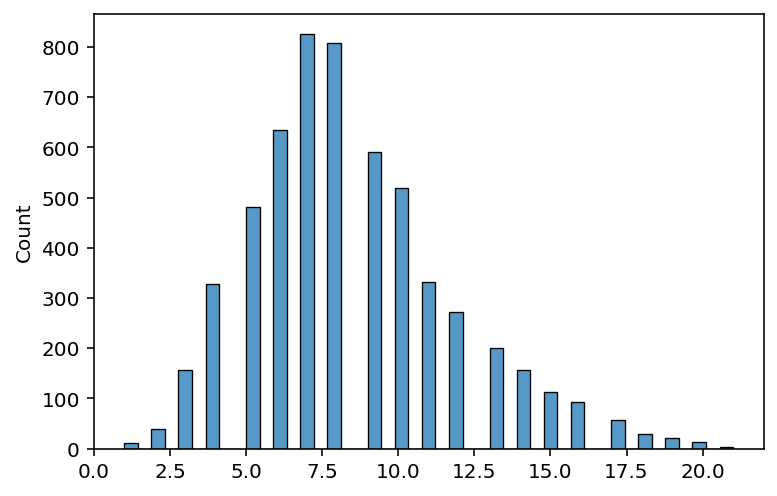

In [132]:
# get length of all the messages in the train set this helps to identify the length of sentence to be fixed for buffer (taken 20)
import seaborn as sns
seq_len = [len(i.split()) for i in train_text]

sns.histplot(seq_len)

In [133]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

#Tokenizing train,test and validation for bert
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 20,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [134]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
#train_img = x = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Transforming the images to tensors as required by ResNet 18

In [135]:
train_imgs = []
count=0
for i,row in traindf.iterrows():
  count+=1
  print(count)
  img=Image.open(data_dir+row['ID']+'.jpg')
  train_imgs.append(Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device))

Streaming output truncated to the last 5000 lines.
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
9

In [136]:
train_imgs_t= torch.stack(train_imgs).to(device)

In [137]:
train_imgs_t = train_imgs_t.reshape(-1,3,224,224)

In [138]:
train_imgs_t.shape

torch.Size([5684, 3, 224, 224])

In [139]:
test_imgs = []
count=0
for i,row in testdf.iterrows():
  count+=1
  print(count)
  img=Image.open(data_dir+row['ID']+'.jpg')
  test_imgs.append(Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [140]:
val_imgs = []
count=0
for i,row in valdf.iterrows():
  count+=1
  print(count)
  img=Image.open(data_dir+row['ID']+'.jpg')
  val_imgs.append(Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)).to(device))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [141]:
val_imgs_t=torch.stack(val_imgs).reshape(-1,3,224,224)
val_imgs_t.shape

torch.Size([710, 3, 224, 224])

### Generating the dataloaders using input as images along with headlines

In [142]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_imgs_t, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_imgs_t, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

### Defining the model and freezing the parameters of BERT and ResNet, we can change this to finetune them also

In [143]:
model_temp = models.resnet18(pretrained=True).to(device)
feature_extractor = torch.nn.Sequential(*list(model_temp.children())[:-1])

In [144]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [145]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [146]:
model1=BERT_Arch(bert).to(device)
model2 = myResNet(feature_extractor)
model2.to(device)
model=MyEnsemble(model1,model2)

### Checking for class imbalance

clickbait:  3548
news:  3557


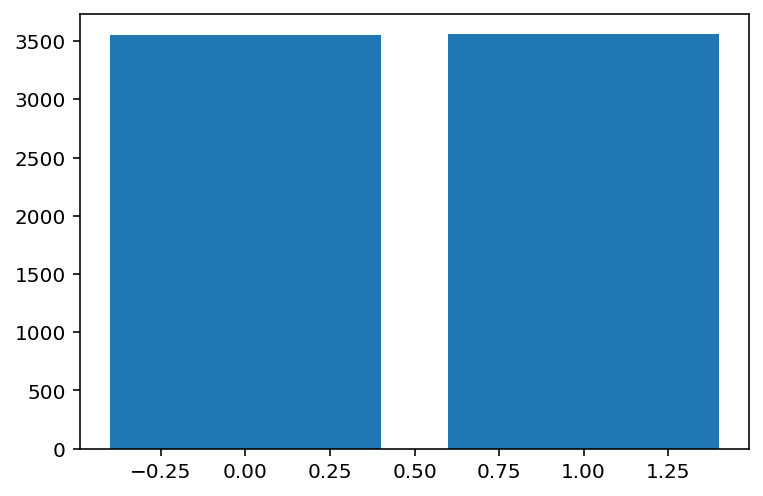

In [147]:
# check for class imbalance
mylist=list(mydf['class_'])
count1=0
count2=0
for i in mylist:
  if i == 1:
    count1+=1
  else:
    count2+=1
print('clickbait: ',count1 )
print('news: ',count2)
#sns.barplot(x=range(2),y=[count1,count2])
count=[count1,count2]
plt.bar(range(len(count)), count)
plt.show()

### Defining model hyperparamers, optimizer and loss function

In [148]:
# optimizer from hugging face transformers
from transformers import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5) 
epochs = 20
cross_entropy = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(),lr=2e-5)

In [149]:
# from sklearn.utils.class_weight import compute_class_weight

# #compute the class weights
# class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

# print("Class Weights:",class_weights)

In [150]:
# # converting list of class weights to a tensor
# weights= torch.tensor(class_weights,dtype=torch.float)

# # push to GPU
# weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
# cross_entropy = nn.CrossEntropyLoss()
# # number of training epochs
# epochs = 10

### Defining Train, Evaluate functions

In [151]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, imgs, labels = batch
    imgs=imgs.reshape((-1,3,224,224))
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask, imgs)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [152]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
     # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, imgs, labels = batch
    imgs=imgs.reshape((-1,3,224,224))
    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask, imgs)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Training the model

In [153]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.646
Validation Loss: 0.600

 Epoch 2 / 20
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.580
Validation Loss: 0.552

 Epoch 3 / 20
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.549
Validation Loss: 0.521

 Epoch 4 / 20
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0

No handles with labels found to put in legend.


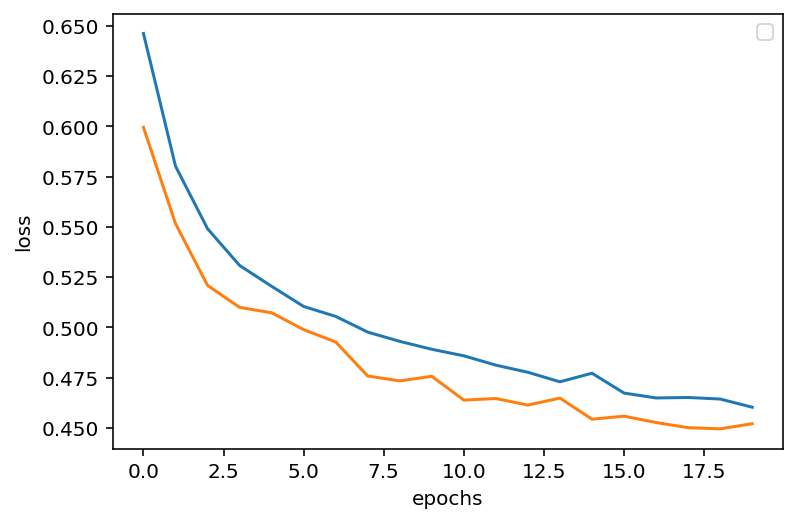

In [154]:
sns.lineplot(data=train_losses)
sns.lineplot(data=valid_losses)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Evaluating the Model

In [155]:
test_imgs_t=torch.stack(test_imgs).to(device)

In [156]:
# get predictions for test data
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_imgs_t, test_y)

# sampler for sampling the data during training
#test_sampler = RandomSampler(test_data)

# dataLoader for train set
test_dataloader = DataLoader(test_data, batch_size=batch_size)
mylist=[]
with torch.no_grad():
  for step,batch in enumerate(test_dataloader):
    sent_id, mask, imgs, labels = batch
    imgs=imgs.reshape(-1,3,224,224)
    print(sent_id.shape, mask.shape, imgs.shape, labels)
    preds=model(sent_id.to(device),mask.to(device),imgs.to(device))
    preds = list(preds.detach().cpu().numpy())
    for pred in preds:
      mylist.append(pred)

torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])
torch.Size([16, 20]) torch.Size([16, 20]) torch.Size([16, 3, 224, 224]) tensor([1, 0, 0, 0, 0, 1,

In [157]:
#mylist

In [158]:
preds=torch.tensor(mylist)
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       387
           1       0.87      0.79      0.83       324

    accuracy                           0.85       711
   macro avg       0.85      0.84      0.85       711
weighted avg       0.85      0.85      0.85       711



In [229]:
# testdf

In [228]:
# testdf['title'][3772]

In [227]:
# my_image_1 = Image.open(data_dir+'1qyyXfQL5jU.jpg')
# my_image_1

In [160]:
# #load weights of best model
# path = 'saved_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# # get predictions for test data
# with torch.no_grad():
#   preds = model(test_seq.to(device), test_mask.to(device))
#   preds = preds.detach().cpu().numpy()

In [ ]:
# |preds = np.argmax(preds, axis = 1)
# print(classification_report(test_y, preds))

In [206]:
# train_seq.shape

In [205]:
# traindf["ID"]

### Comparing our model with training using only Headlines

In [207]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [208]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [209]:
class BERT_Arch1(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch1, self).__init__()
      self.bert = bert 
      # dropout layer
      self.dropout = nn.Dropout(0.3)
      # relu activation function
      self.relu =  nn.ReLU()
      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
      #softmax activation function
      self.softmax = nn.Softmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc2(x)
      # apply softmax activation
      x = self.softmax(x)

      return x

In [210]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch1(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5) 
#optimizer = Adam(model.parameters(),lr=2e-5)

In [211]:
epochs = 35
cross_entropy = nn.CrossEntropyLoss()

In [212]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [213]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
     # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [214]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.688
Validation Loss: 0.687

 Epoch 2 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.680
Validation Loss: 0.672

 Epoch 3 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.670
Validation Loss: 0.660

 Epoch 4 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.662
Validation Loss: 0.653

 Epoch 5 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.652
Validation Loss: 0.646

 Epoch 6 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  of    178.

Evaluating...

Training Loss: 0.644
Validation Loss: 0.637

 Epoch 7 / 35
  Batch    50  of    178.
  Batch   100  of    178.
  Batch   150  

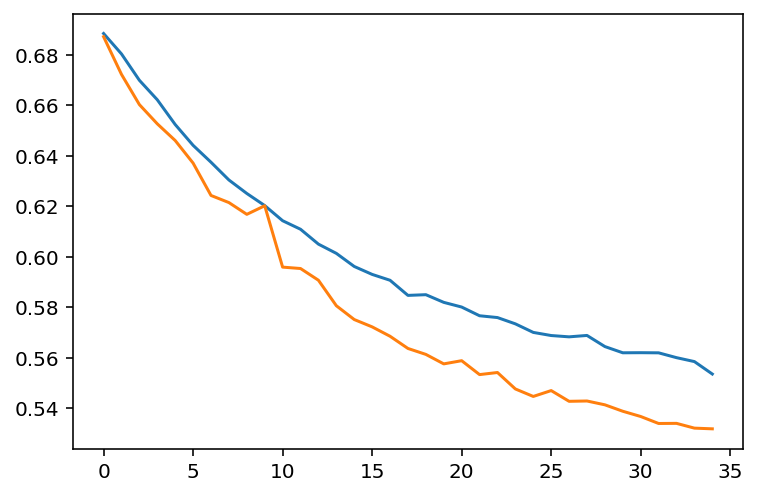

In [216]:
sns.lineplot(data=train_losses)
sns.lineplot(data=valid_losses)
plt.show()

In [217]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       387
           1       0.75      0.76      0.75       324

    accuracy                           0.77       711
   macro avg       0.77      0.77      0.77       711
weighted avg       0.77      0.77      0.77       711



### Comparing our model with training using only Thumbnails

In [230]:
class myResNet1(nn.Module):
    def __init__(self, resnet):
      
      super(myResNet1, self).__init__()
      self.resnet = resnet.to(device)
      # dropout layer
      self.dropout = nn.Dropout(0.3).to(device)
      # relu activation function
      self.relu =  nn.ReLU().to(device)
      # dense layer 1
      self.fc1 = nn.Linear(512,512).to(device)
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2).to(device)
      #softmax activation function
      self.softmax = nn.Softmax(dim=1).to(device)

    def forward(self,img):
      x = self.resnet(img)
      x = x.reshape(-1, 512)
      x=self.fc1(x)
      x=self.relu(x)
      x=self.fc2(x)
      x=self.softmax(x)
      return x

In [231]:
train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

In [232]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_imgs_t, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_imgs_t, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [233]:
model_temp = models.resnet18(pretrained=True).to(device)
feature_extractor = torch.nn.Sequential(*list(model_temp.children())[:-1])

In [234]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [235]:
model = myResNet1(feature_extractor.to(device))
model.to(device)

myResNet1(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [236]:
# optimizer from hugging face transformers
from transformers import AdamW
from torch.optim import Adam

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5) 
#optimizer = Adam(model.parameters(),lr=2e-5)

epochs = 10
cross_entropy = nn.CrossEntropyLoss()

In [237]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    image, labels = batch
    image = image.reshape((-1,3,224,224)).to(device)

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(image)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [238]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
     # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    image, labels = batch
    image = image.reshape((-1,3,224,224)).to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(image)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [239]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.654
Validation Loss: 0.608

 Epoch 2 / 10
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.597
Validation Loss: 0.569

 Epoch 3 / 10
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0.569
Validation Loss: 0.546

 Epoch 4 / 10
  Batch    50  of    356.
  Batch   100  of    356.
  Batch   150  of    356.
  Batch   200  of    356.
  Batch   250  of    356.
  Batch   300  of    356.
  Batch   350  of    356.

Evaluating...

Training Loss: 0

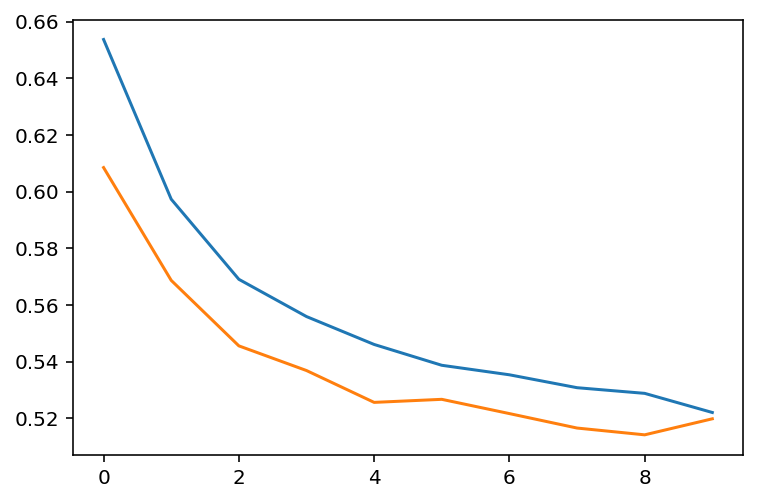

In [240]:
import seaborn as sns
sns.lineplot(data=train_losses)
sns.lineplot(data=valid_losses)
plt.show()

In [242]:
# get predictions for test data
with torch.no_grad():
  test_imgs_t = test_imgs_t.reshape((-1, 3, 224, 224))
  preds = model(test_imgs_t.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

# Thank You
Team: Pied Piper